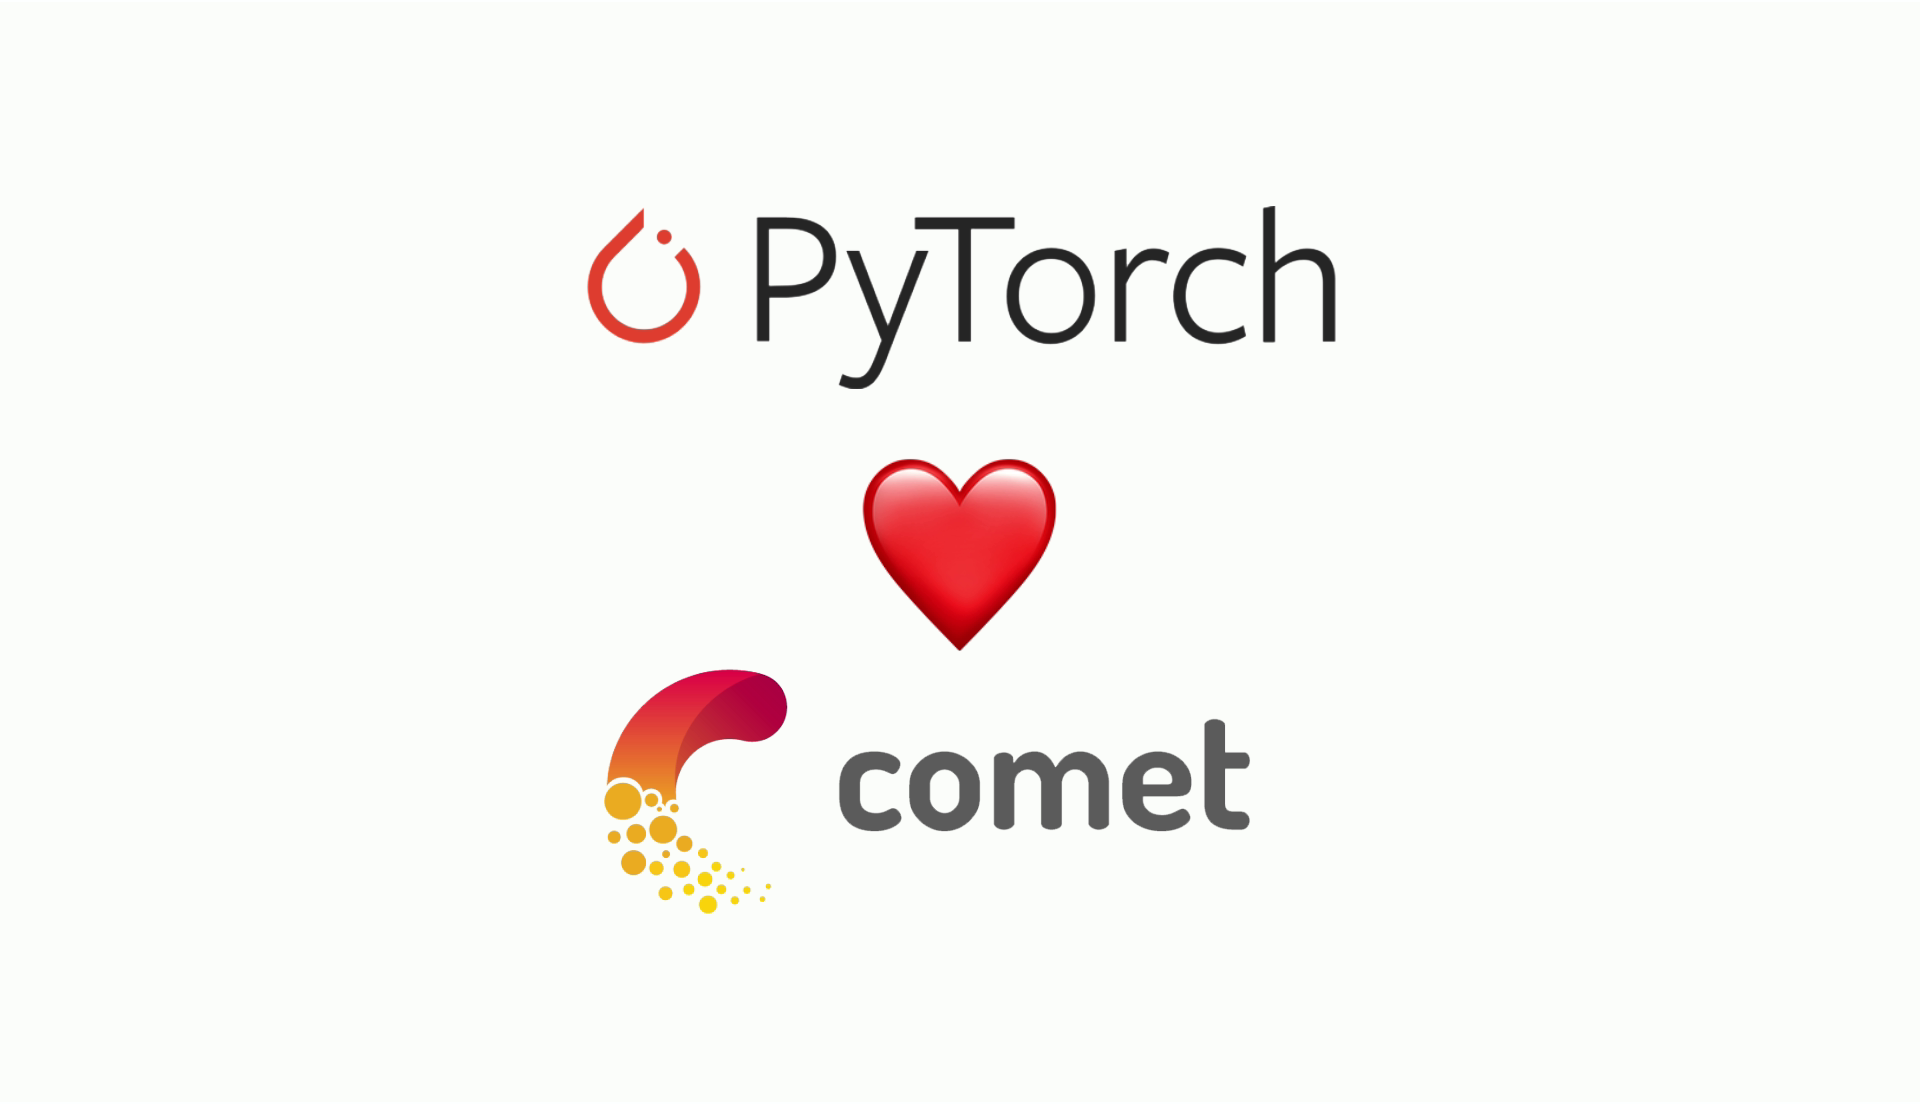

[Pytorch](https://pytorch.org/) is an open source machine learning framework that accelerates the path from research prototyping to production deployment. 


[Comet](https://www.comet.ml/site/data-scientists/?utm_campaign=pytorch&utm_medium=colab) is an MLOps Platform that is designed to help Data Scientists and Teams build better models faster! Comet provides tooling to track, Explain, Manage, and Monitor your models in a single place! It works with Jupyter Notebooks and Scripts and most importantly it's 100% free to get started!


Find out more about our other integrations [here](https://www.comet.ml/docs/v2/integrations/overview/)

# Install Dependencies

In [ ]:
!pip install comet_ml --quiet

# Initialize Comet

In [ ]:
import comet_ml
comet_ml.init(project_name='comet-pytorch')

# Import Dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
from tqdm import tqdm

# Define Parameters

In [ ]:
hyper_params = {
    "batch_size": 100,
    "num_epochs": 2,
    "learning_rate": 0.01
}
experiment = comet_ml.Experiment()
experiment.log_parameters(hyper_params)

# Load Data

In [ ]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = datasets.MNIST(root='./data/',
                           train=False,
                           transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=hyper_params['batch_size'],
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=hyper_params['batch_size'],
                                          shuffle=False)

# Define Model and Optimizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        return x

model = Net().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['learning_rate'])

# Train a Model

In [ ]:
def train(model, optimizer, criterion, dataloader, epoch, experiment):
    model.train()
    total_loss = 0
    correct = 0
    for batch_idx, (images, labels) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
                
        loss  = criterion(outputs, labels)  
        pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        loss.backward()
        optimizer.step()

        # Compute train accuracy
        batch_correct = pred.eq(labels.view_as(pred)).sum().item() 
        batch_total = labels.size(0)
 
        total_loss += loss.item()
        correct += batch_correct

        # Log batch_accuracy to Comet; step is each batch
        experiment.log_metric("batch_accuracy", batch_correct / batch_total)

    total_loss /= len(dataloader.dataset)
    correct /= len(dataloader.dataset)

    experiment.log_metrics({"accuracy": correct, "loss": total_loss}, epoch=epoch)

In [ ]:
with experiment.train():
  for epoch in range(hyper_params['num_epochs'] + 1):
    train(model, optimizer, criterion, train_loader, epoch, experiment)

# Evaluate Model

In [ ]:
def test(model, optimizer, criterion, dataloader, epoch, experiment):
    model.eval()

    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

        total_loss /= len(dataloader.dataset)
        correct /= len(dataloader.dataset)

        experiment.log_metrics({"accuracy": correct, "loss": total_loss}, epoch=epoch)

In [ ]:
with experiment.test():
  test(model, optimizer, criterion, test_loader, epoch, experiment)

# End Experiment 

In [ ]:
experiment.end()